In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [2]:
# Directory of Data for images
datadir = 'Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\Github\Data Science\Self-Driving Car\Data\IMG\center_2019_03_28_01_13_54_369.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\left_2019_03_28_01_13_54_369.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\right_2019_03_28_01_13_54_369.jpg,0.0,0.0,0.0,0.481111
1,D:\Github\Data Science\Self-Driving Car\Data\IMG\center_2019_03_28_01_13_54_474.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\left_2019_03_28_01_13_54_474.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\right_2019_03_28_01_13_54_474.jpg,0.0,0.0,0.0,0.476287
2,D:\Github\Data Science\Self-Driving Car\Data\IMG\center_2019_03_28_01_13_54_580.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\left_2019_03_28_01_13_54_580.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\right_2019_03_28_01_13_54_580.jpg,0.0,0.0,0.0,0.471512
3,D:\Github\Data Science\Self-Driving Car\Data\IMG\center_2019_03_28_01_13_54_680.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\left_2019_03_28_01_13_54_680.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\right_2019_03_28_01_13_54_680.jpg,0.0,0.0,0.0,0.466785
4,D:\Github\Data Science\Self-Driving Car\Data\IMG\center_2019_03_28_01_13_54_788.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\left_2019_03_28_01_13_54_788.jpg,D:\Github\Data Science\Self-Driving Car\Data\IMG\right_2019_03_28_01_13_54_788.jpg,0.0,0.0,0.0,0.461174


In [3]:
# Function to extract image name
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [4]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_03_28_01_13_54_369.jpg,left_2019_03_28_01_13_54_369.jpg,right_2019_03_28_01_13_54_369.jpg,0.0,0.0,0.0,0.481111
1,center_2019_03_28_01_13_54_474.jpg,left_2019_03_28_01_13_54_474.jpg,right_2019_03_28_01_13_54_474.jpg,0.0,0.0,0.0,0.476287
2,center_2019_03_28_01_13_54_580.jpg,left_2019_03_28_01_13_54_580.jpg,right_2019_03_28_01_13_54_580.jpg,0.0,0.0,0.0,0.471512
3,center_2019_03_28_01_13_54_680.jpg,left_2019_03_28_01_13_54_680.jpg,right_2019_03_28_01_13_54_680.jpg,0.0,0.0,0.0,0.466785
4,center_2019_03_28_01_13_54_788.jpg,left_2019_03_28_01_13_54_788.jpg,right_2019_03_28_01_13_54_788.jpg,0.0,0.0,0.0,0.461174


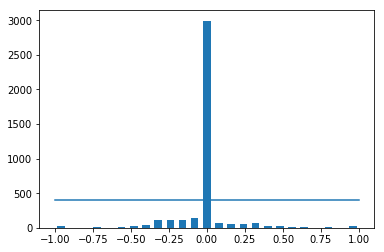

In [5]:
num_bins = 25
# threshold for bin sample values
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
# to center values to 0 
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin));

total data: 3936
removed: 2593
remaining: 1343


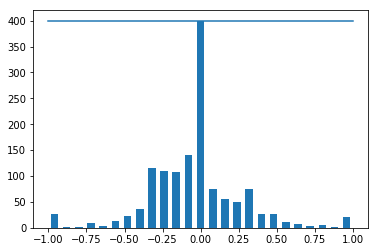

In [6]:
print('total data:', len(data))
remove_list = []
# Removing Steering angle part having bins greater than 400 samples
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
       list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin));

In [7]:
data.iloc[1]

center      center_2019_03_28_01_13_55_323.jpg
left        left_2019_03_28_01_13_55_323.jpg  
right       right_2019_03_28_01_13_55_323.jpg 
steering   -0.505882                          
throttle    1                                 
reverse     0                                 
speed       2.677                             
Name: 9, dtype: object

## Loading Image paths and Steering Angles

In [7]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        # indexed data the steering angle image
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

## Train Test Split

Training Samples: 3223
Valid Samples: 806


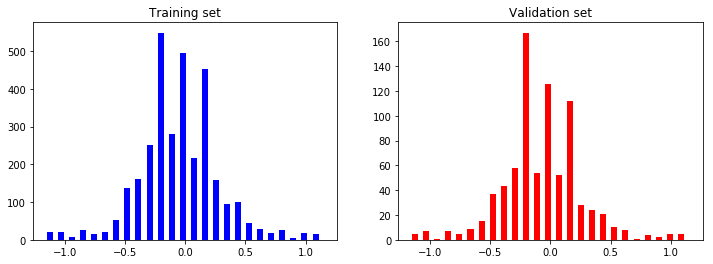

In [8]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set');

## Data Augmentation

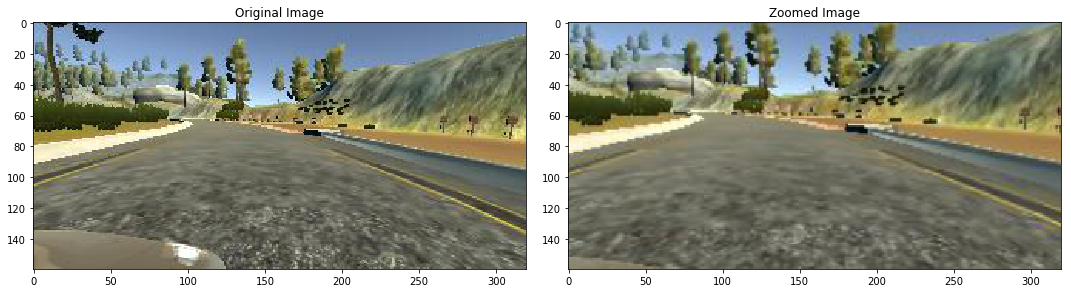

In [9]:
# Function to zoom Images
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image');

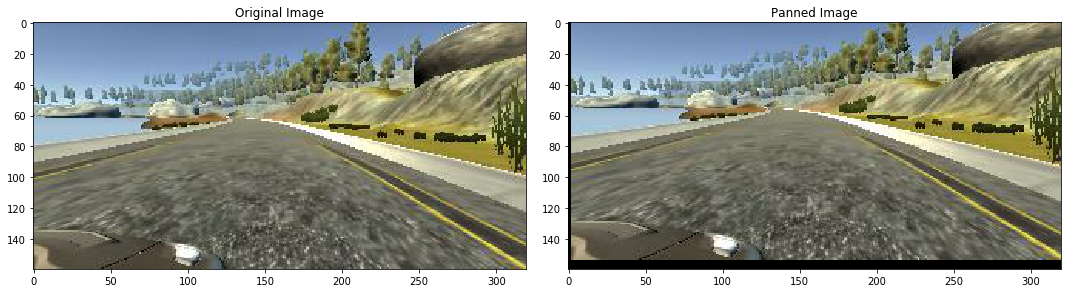

In [10]:
# Function to pan Images
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image');

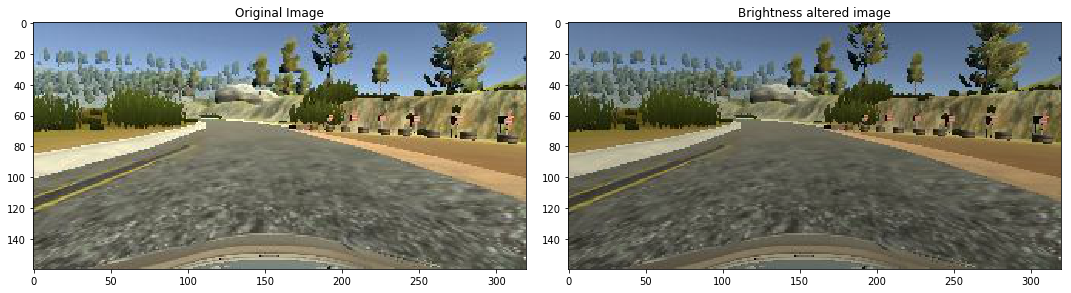

In [11]:
# Function to change Brightness
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image');

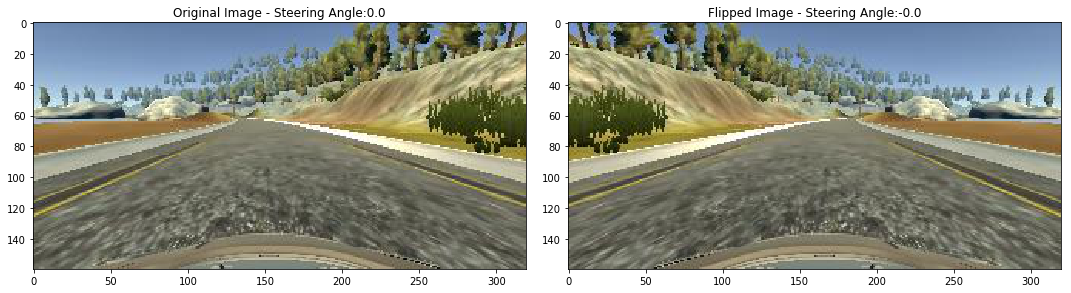

In [12]:
# Function to Flip Images Horizontally
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle));

In [13]:
# Function to Apply Image Augmentations randomly
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

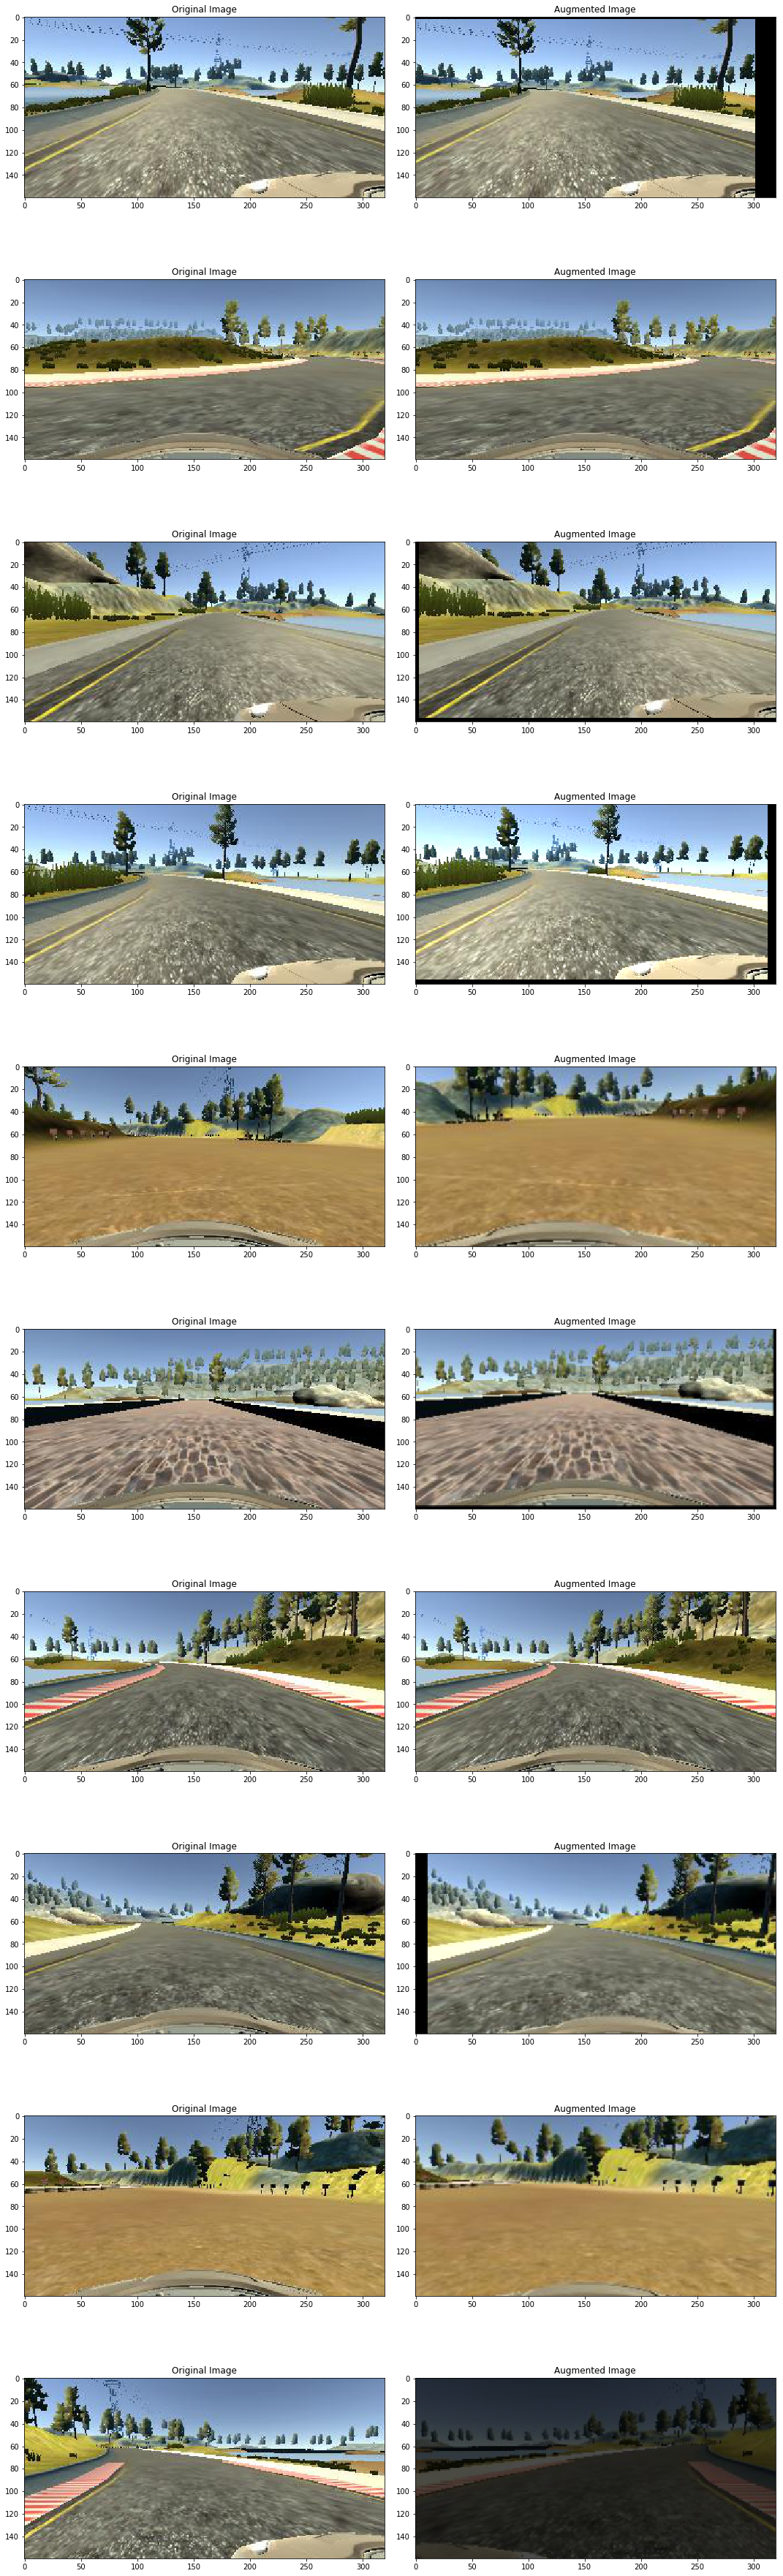

In [14]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

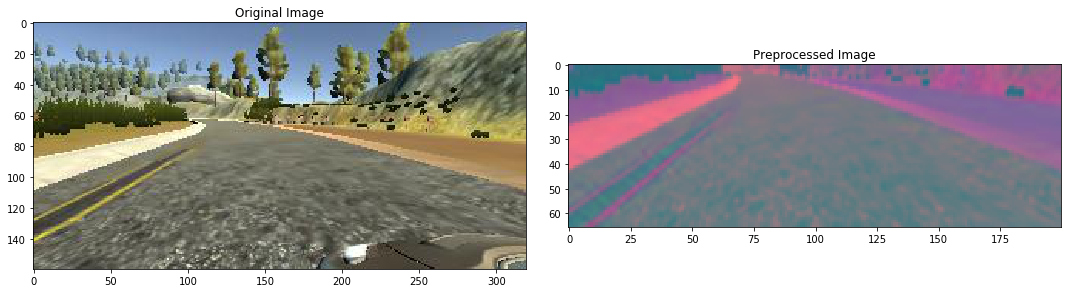

In [15]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image');

In [16]:
# Function for Batch Generation of Images for Training and Test Set
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

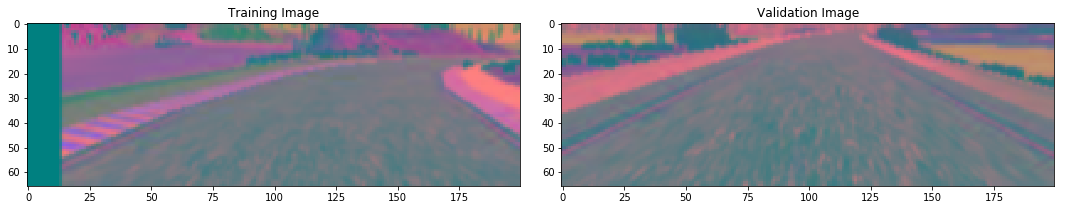

In [17]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image');

In [18]:
def nvidia_model():
  model = Sequential([
  Conv2D(24, (5, 5) ,strides=(2, 2), input_shape=(66, 200, 3), activation='elu'),
  Conv2D(36, (5, 5) ,strides=(2, 2), activation='elu'),
  Conv2D(48, (5, 5) ,strides=(2, 2), activation='elu'),
  Conv2D(64, (3, 3) ,activation='elu'),
  Conv2D(64, (3, 3) ,activation='elu'),
  Flatten(),
  Dense(100, activation = 'elu'),
  Dense(50, activation = 'elu'),
  Dense(10, activation = 'elu'),
  Dense(1, activation = 'linear') ,       
  ])
  return model

In [19]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [20]:
optimizer = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=optimizer)

In [21]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 358s 1s/step - loss: 0.1012 - val_loss: 0.0887
Epoch 2/10
300/300 [==============================] - 305s 1s/step - loss: 0.0948 - val_loss: 0.0820
Epoch 3/10
300/300 [==============================] - 267s 889ms/step - loss: 0.0919 - val_loss: 0.0777
Epoch 4/10
300/300 [==============================] - 201s 670ms/step - loss: 0.0892 - val_loss: 0.0769
Epoch 5/10
300/300 [==============================] - 195s 650ms/step - loss: 0.0862 - val_loss: 0.0707
Epoch 6/10
300/300 [==============================] - 199s 663ms/step - loss: 0.0828 - val_loss: 0.0673
Epoch 7/10
300/300 [==============================] - 188s 628ms/step - loss: 0.0798 - val_loss: 0.0676
Epoch 8/10
300/300 [==============================] - 199s 663ms/step - loss: 0.0807 - val_loss: 0.0640
Epoch 9/10
300/300 [==============================] - 189s 629ms/step - loss: 0.0784 - val_loss: 0.0677
Epoch 10/10
300/300 [==============================] - 189s 630ms/step

In [22]:
model.save('model.h5')

Text(0.5, 1.0, 'Loss Curves')

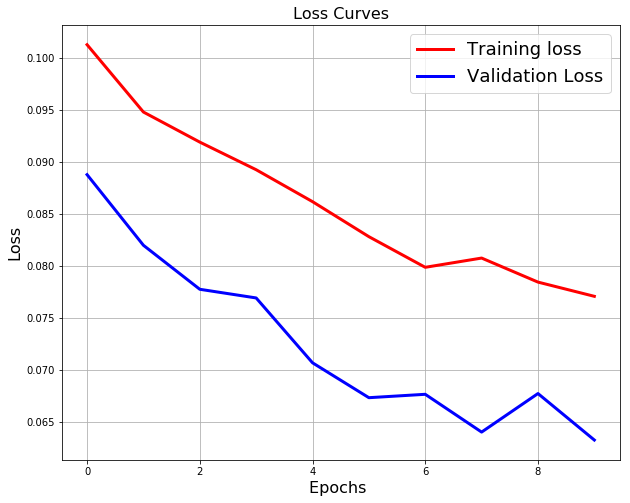

In [24]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)